<a href="https://colab.research.google.com/github/PedroHGMS/rna_trabalho_final/blob/main/trabalho_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
proj_path = 'drive/MyDrive/rna/trabalho_final/'

Mounted at /content/drive


In [ ]:
pip install import_ipynb ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importando funções que carregam os datasets
import import_ipynb
import ipynb
import sys, os
sys.path.append(os.path.abspath(proj_path+'Datasets/'))
from ipynb.fs.full.load_datasets import *

In [ ]:
# Funções gerais

def normalize(X):
    result = ((X-np.min(X,0))/(np.max(X,0)-np.min(X,0)))
    result = np.nan_to_num(result, nan=0)
    return result

def print_dictionary(d):
  for k in d.keys():
    if type(d[k]) == np.ndarray:
      print(f"{k}.shape: {d[k].shape}")
    elif type(d[k])==int:
      print(f"{k}: {d[k]:.3E}")
    else:
      print(f"{k}: {d[k]}")
  return

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import csv
import math
import time
import csv
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback
from scipy.stats import multivariate_normal
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import clear_output

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers, layers, Sequential, models, optimizers
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [ ]:
# Sumário dos datasets
datasets = [
            load_dataset_sonar(),
            load_dataset_ionosphere(),
            load_dataset_real_estate(),
            load_dataset_wine(),
            load_dataset_statlog()
            ]


for i in range(len(datasets)):
  # Carregando datasets
  dataset = datasets[i]
  print(f'\nDataset {i+1}:')
  print_dictionary(dataset)

In [ ]:
# Definição de funções para o k-fold
def split_dataset(X, Y, ratio):
  '''
    Separa X e Y de acordo com os ratio passado.
    input:
      X: um np.ndarray (N, d)
      Y: um np.ndarray (N, 1)
      ratio: uma lista ou ndarray com 2 ou 3 valores
    output:
      Um dicionário com a divisão de X e Y em 'train' e 'test', se ratio tiver 2 valores,
      ou 'train', 'val' e 'test'
  '''
  return_dict = {}
  ratio = np.array(ratio)

  # Confere valores de entrada
  if (not (np.isclose(ratio.sum(), 1))) or (ratio.shape[0]==0) or (ratio.shape[0]>=4):
    print('Erro: Ratio deve ter 2 ou 3 valores e a soma dos valores deve ser igual a 1.')
    return {}

  # Número de amostras e dimensão de entrada
  N, d = X.shape

  # Faz as permutações, para embaralhar X e Y de forma igual
  permutations = np.random.permutation(X.shape[0])
    
  # Valores do limite entre cada partição
  ratio_indices = (N*ratio.cumsum()).astype(int)

  # Divisão de treino
  return_dict['X_train'] = X[permutations[0:ratio_indices[0]]]
  return_dict['Y_train'] = Y[permutations[0:ratio_indices[0]]]

  # Divisão
  if(ratio.shape[0]==2):
    return_dict['X_test'] = X[permutations[ratio_indices[0]:ratio_indices[1]]]
    return_dict['Y_test'] = Y[permutations[ratio_indices[0]:ratio_indices[1]]]
  elif(ratio.shape[0]==3):
    return_dict['X_val'] = X[permutations[ratio_indices[0]:ratio_indices[1]]]
    return_dict['Y_val'] = Y[permutations[ratio_indices[0]:ratio_indices[1]]]

    return_dict['X_test'] = X[permutations[ratio_indices[1]:ratio_indices[2]]]
    return_dict['Y_test'] = Y[permutations[ratio_indices[1]:ratio_indices[2]]]
  return return_dict

def split_k_fold(X, Y, k=10):
  '''
    Divide X e Y em k folds, não aleatoriza
    Retorna uma tuple com arrays
  '''
  # Número de amostras e dimensão de entrada
  N, d = X.shape
  
  # limite entre cada fold em indices
  lim = np.linspace(0, N, k+1).astype(int)
  
  X_array = []
  Y_array = []
  for i in range(k):
    idx = np.array(range(lim[i],lim[i+1]))
    X_array.append(X[idx])
    Y_array.append(Y[idx])
  return (X_array, Y_array)

In [ ]:
# Função do k-fold

def kfold(dataset, args={}):
  '''
    Calcula o erro de validação k-fold para um dataset
    inputs:
      model: modelo não treinado do keras
      dataset: dicionário com X e Y
      ratio = divisão entre o dataset de treinamento e teste
    output:
      Retorna o erro de validação e de teste de cada fold
      Um array de shape (num_rep, k, 2), contendo os erros de validaçao e de teste respectivamente
  '''
  # Recuperando argumentos
  config = {
    'lamb': 0,  
    'k': 10, 
    'num_rep': 1, 
    'n_neuronios': 10, 
    'num_epochs': 100, 
    'ratio': [.7, .3], 
    'train_verbose': False, 
    'leave_tqdm': True
  }
  config.update(args)
  
  lamb = config['lamb']
  k = config['k']
  num_rep = config['num_rep']
  n_neuronios = config['n_neuronios'] 
  num_epochs = config['num_epochs']
  ratio = config['ratio']
  train_verbose = config['train_verbose']
  leave_tqdm = config['leave_tqdm']

  # Recuperando dataset
  X = dataset['X']
  Y = dataset['Y']
  name = dataset['name']
  task = dataset['task']


  if task=='regression':
    track_metric = 'mse'
    metric_mode = 'min'
  elif task=='classification':
    track_metric = 'binary_accuracy'
    metric_mode = 'max'
    Y[Y==-1] = 0
  else:
    print(f'"Task" do dataset inválida, deve ser "regression" ou "classificação". Atual: {task}')

  # Número de amostras e dimensão de entrada
  N, d = X.shape
  
  erros_rep = np.zeros((num_rep, k, 2))
  rep_pbar = tqdm(range(num_rep), leave=leave_tqdm)
  for rep in rep_pbar:
      rep_pbar.set_description(f'Repeticoes do k-fold (lambda = {lamb:.2E})')
      # Sepração entre treino e teste
      dataset_separado =  split_dataset(X, Y, ratio = ratio)
      X_test, Y_test = dataset_separado['X_test'], dataset_separado['Y_test']
      X_train, Y_train = dataset_separado['X_train'], dataset_separado['Y_train']

      # k-fold
      # Separação dos k-folds
      X_folds, Y_folds = split_k_fold(X=X_train, Y=Y_train, k=k)

      # Loop para usar cada fold para validação de cada vez
      melhor_erro_val = np.zeros((k))
      erro_teste = np.zeros((k))
      kfold_pbar = tqdm(range(k), leave=False)
      for i in (kfold_pbar):
        kfold_pbar.set_description('k-fold')
        # Separação dos indices de cada k-fold (valores de 0 a k)
        fold_idx = list(range(k))
        val_idx = fold_idx.pop(i)
        train_idx = fold_idx

        # Separação de cada k-fold e transformando em um np.ndarray
        X_train_folds = np.concatenate([X_folds[e] for e in train_idx])
        X_val_fold = X_folds[val_idx]

        Y_train_folds = np.concatenate([Y_folds[e] for e in train_idx])
        Y_val_fold = Y_folds[val_idx]

        # Definição do modelo
        model = Sequential([
          InputLayer(input_shape=(d)),
          Dense(n_neuronios, activation='tanh', kernel_regularizer=regularizers.L2(l2=lamb)),
          Dense(1, activation='linear', kernel_regularizer=regularizers.L2(l2=lamb))
        ])

        # Compilação do modelo, escolhendo o otimizador, função de perda e métrica de validação
        model.compile(optimizer='adam',
                      loss='mse',
                      metrics=[track_metric])

        # Definindo um checkpoint para salvar o modelo com melhor metrica de validação
        checkpoint = ModelCheckpoint(filepath=f'Modelos/melhor_modelo_{i}.hdf5', 
                                  monitor=f'val_{track_metric}',
                                  verbose=0, 
                                  save_best_only=True,
                                  mode=metric_mode)

        # Treinamento com X_train_folds
        callbacks = []
        callbacks.append(checkpoint)
        if train_verbose==True:
          callbacks.append(TqdmCallback(verbose=1, leave=False))

        history = model.fit(x=X_train_folds, y=Y_train_folds, validation_data=(X_val_fold, Y_val_fold),
                            epochs=num_epochs, verbose=0, callbacks=[checkpoint])

        # Gráficos de treinamento
    #     plt.plot(np.array(history.history[f'{track_metric}']).reshape(-1,10).mean(axis=1).reshape(-1,1),label=f'train {track_metric}')
    #     plt.plot(np.array(history.history[f'val_{track_metric}']).reshape(-1,10).mean(axis=1).reshape(-1,1),label=f'val {track_metric}')
    #     plt.legend()
    #     plt.show()

        # Validação com X_val_fold
        if metric_mode=='min':
          melhor_erro_val[i] = np.array(history.history[f'val_{track_metric}']).min()
        elif metric_mode=='max':
          melhor_erro_val[i] = np.array(history.history[f'val_{track_metric}']).max()
        else:
          print(f'metric_mode inválida. Atual {metric_mode}')


      # Erro de validação médio dos k-folds
      # plt.hist(melhor_erro_val, bins=k)
      # plt.show()
#       print('Erro de validação: ',melhor_erro_val.mean(),'+-', melhor_erro_val.var()**0.5)

    #   Teste com X_test
      test_pbar = tqdm(range(k), leave=False)
      for i in test_pbar:
        test_pbar.set_description('Testando modelos')
        melhor_modelo = models.load_model(f'Modelos/melhor_modelo_{i}.hdf5')
        erro_teste[i] = melhor_modelo.evaluate(X_test,Y_test, verbose=0, return_dict=True)[track_metric]

      # plt.hist(erro_teste, bins=k)
      # plt.show()
#       print('Erro de Teste:     ',erro_teste.mean(),'+-', erro_teste.var()**0.5)
      
      erros_rep[rep] = np.array((np.copy(melhor_erro_val), np.copy(erro_teste))).T

#   print('Erro de validação: ',erros_rep[:,:,0].mean(),'+-', erros_rep[:,:,0].var()**0.5)
#   print('Erro de Teste:     ',erros_rep[:,:,1].mean(),'+-', erros_rep[:,:,1].var()**0.5)
  return erros_rep
  

###########################
# Testes da função K-fold #
###########################

# # Carregando dataset
# dataset = load_dataset_sonar()
# dataset['X'] = normalize(dataset['X'])
# k = 3
# split = [.8, .2]

# # Printando o dataset
# print('Dataset:')
# print_dictionary(dataset)
# print('#'*30)

# config = {
#   'lamb':1e-2, 
#   'num_rep': 5, 
#   'n_neuronios':10, 
#   'num_epochs':50, 
#   'k':10, 
#   'ratio':split
# }

# r = kfold(dataset, config)

Dataset:
X.shape: (208, 60)
Y.shape: (208,)
task: classification
name: sonar
##############################


  0%|          | 0/20 [00:00<?, ?it/s]

Erro de validação:  0.8250000029802322 +- 0.12572321564696579


  0%|          | 0/20 [00:00<?, ?it/s]

Erro de Teste:      0.6321428641676903 +- 0.07949493250673535


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

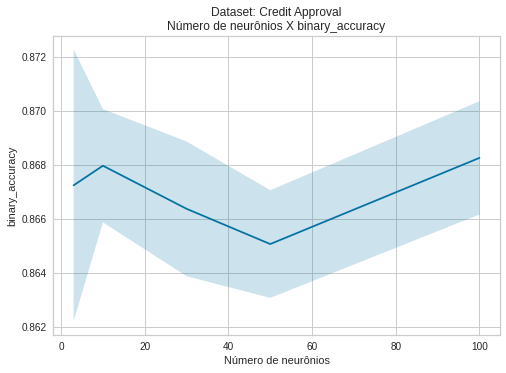

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

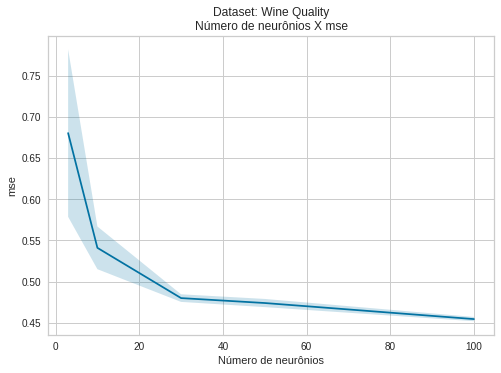

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

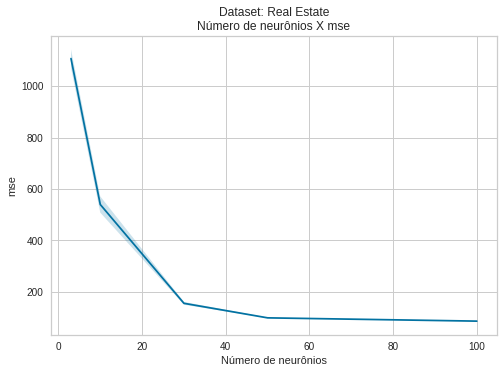

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Testes para descobrir qunatos neurônios são precisos para cada dataset
datasets = [
#             load_dataset_sonar(),
#             load_dataset_ionosphere(),
            load_dataset_real_estate(),
#             load_dataset_wine(),
#             load_dataset_statlog()
            ]

neuronios = [30]
num_epochs = 50000
num_rep = 3

tqdm_datasets = tqdm(range(len(datasets)))
for i in tqdm_datasets:#range(len(datasets)):
  # Carregando datasets
  dataset = datasets[i]
  # print(f'\nDataset {i+1}:')
  # print_dictionary(dataset)
  tqdm_datasets.set_description(f"Datasets | Atual: {dataset['name']}")

  dataset['X'] = normalize(dataset['X'])
  task = dataset['task']
  if dataset['task']=='classification':
    dataset['Y'][dataset['Y']==-1] = 0

  # Definindo o tipo de tarefa
  if task=='regression':
    track_metric = 'mse'
    metric_mode = 'min'
  elif task=='classification':
    track_metric = 'binary_accuracy'
    metric_mode = 'max'
  else:
    print('Erro, task não reconhecida.')

  # Testando vários números de neurônios
  erros_neuronios = np.zeros((len(neuronios), num_rep))
  tqdm_neuronios = tqdm(range(len(neuronios)), leave=False)
  for num_neuronios_idx in tqdm_neuronios:
    num_neuronios = neuronios[num_neuronios_idx]
    tqdm_neuronios.set_description(f"Num_neur | Atual: {num_neuronios}")

    # Repetindo o treinamento várias vezes
    erros_rep = np.zeros((num_rep))
    tqdm_it = tqdm(range(num_rep), leave=False)
    for it in tqdm_it:
      tqdm_it.set_description(f"Repetições")

      # Definindo modelo
      model = tf.keras.Sequential([
        InputLayer(input_shape=(dataset['X'].shape[1])),
        Dense(num_neuronios, activation='tanh'),
        Dense(1, activation='linear')
      ])

      # Learning rate schedule
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
          initial_learning_rate=0.0007,
          decay_steps=50,
          decay_rate=0.975)

      # Otimizadores
      adam = tf.keras.optimizers.Adam(
          learning_rate=lr_schedule,
          beta_1=0.9,
          beta_2=0.999
      )

      sgd = tf.keras.optimizers.SGD(
          learning_rate=lr_schedule
      )

      # Compilando modelo
      model.compile(optimizer=adam, metrics=[track_metric],
                loss='mse')
      
      # Treinamento
      history = model.fit(dataset['X'], dataset['Y'], batch_size=128, epochs=num_epochs, verbose=0)

      # Erro de cada treinamento de cada numero de neuronios
      if metric_mode=='min':
        erros_rep[it] = np.array(history.history[track_metric]).min()
      elif metric_mode=='max':
        erros_rep[it] = np.array(history.history[track_metric]).max()

    # Erro de treinamento cada tipo de neurônios
    erros_neuronios[num_neuronios_idx, :] = erros_rep
  # Plot de erro para cada neurônios
  plt.plot(neuronios, erros_neuronios.mean(1))
  plt.fill_between(neuronios, erros_neuronios.mean(1)+erros_neuronios.var(1)**0.5, erros_neuronios.mean(1)-erros_neuronios.var(1)**0.5, alpha=0.2)
  plt.title(f"Dataset: {dataset['name']}\nNúmero de neurônios X {track_metric}")
  plt.ylabel(track_metric)
  plt.xlabel('Número de neurônios')
  plt.show()

In [ ]:
# teste de um dataset
dataset = load_dataset_sonar()
dataset['X'] = normalize(dataset['X'])
task = dataset['task']
if dataset['task']=='classification':
  dataset['Y'][dataset['Y']==-1] = 0

# Definindo o tipo de tarefa
if task=='regression':
  track_metric = 'mse'
  metric_mode = 'min'
elif task=='classification':
  track_metric = 'binary_accuracy'
  metric_mode = 'max'

t = time.time()

print_dictionary(dataset)

model = Sequential([
    InputLayer(input_shape=(dataset['X'].shape[1])),
    Dense(30, activation='tanh'),
    Dense(1, activation='linear')
])

# Learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=3e-3,
    decay_steps=3000,
    decay_rate=0.5,
    staircase=True
)

# Otimizadores
adam = Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999
)

sgd = SGD(
    learning_rate=lr_schedule
)

model.compile(optimizer=sgd, metrics=[track_metric],
              loss='mse')
callbacks=[]
# callbacks=[TqdmCallback(verbose=1)]
history = model.fit(dataset['X'], dataset['Y'], batch_size=1024, epochs=1000, verbose=1, validation_split=1/3, callbacks=callbacks, validation_freq=10)

plt.plot(np.array(history.history[track_metric]).reshape(-1,10).mean(axis=1).reshape(-1,1),label=f'train {track_metric}')
plt.plot(np.array(history.history[f'val_{track_metric}']),label=f'val {track_metric}')
plt.legend()
plt.show()

plt.plot(np.array(history.history['loss']).reshape(-1,10).mean(axis=1).reshape(-1,1),label='train loss')
plt.plot(np.array(history.history['val_loss']),label='val loss')
plt.legend()
plt.show()

print(f'Tempo de exec: {time.time()-t}s')

In [ ]:
#####################
# Busca Exponencial #
#####################

# Configurações da busca do lambda
# Intervalo inicial de procura do lambda
# ini é o início do intervalo e end é o final
lamb_ini_0 = 1e-4
lamb_end_0 = 1e2

# Quantas vezes escolher um novo intervalo menor para busca
repeticoes_busca = 1

# Outras configurações de treinamento e validação
config = {
  'lamb': 0, # Vai ser encontrado
  'k': 10, # 10-fold
  'num_rep': 5, # Rpetetições do k-fold
  'n_neuronios': 0, # Diferente para cada dataset 
  'num_epochs': 500, 
  'ratio': [.7, .3], # split de treinamento/teste para o k-folds
  'train_verbose': False, 
  'leave_tqdm': False
}

#############################
# Início da Busca do lambda #
#############################

# Carregando datasets
datasets = [
            load_dataset_sonar(),
            load_dataset_ionosphere(),
            load_dataset_real_estate(),
            load_dataset_wine(),
            load_dataset_statlog()
            ]
# Checando se o arquivo de resultados exite
if exists('erros_exp.npy'):
  results=np.load('erros_exp.npy', allow_pickle=True)[()]
else:
  results = {}

# Loop para cada dataset
tqdm_datasets = tqdm(datasets)
for dataset in tqdm_datasets:
  tqdm_datasets.set_description(f'Dataset {dataset["name"]}: ')
  
  # Checando se esse dataset já foi usado
  if dataset['name'] in results.keys():
    continue
  
  # Recupenrando informações sobre o dataset
  config.update({'n_neuronios': dataset['min_neurons']})
  task = dataset['task']  
  if task=='regression':
    track_metric = 'mse'
    metric_mode = 'min'
  elif task=='classification':
    track_metric = 'binary_accuracy'
    metric_mode = 'max'
    dataset['Y'][dataset['Y']==-1] = 0
  else:
    print(f'"Task" do dataset inválida, deve ser "regression" ou "classificação". Atual: {task}')

  # Busca exponencial
  erros_array = []
  
  # Resetando intervalos
  lamb_ini = lamb_ini_0
  lamb_end = lamb_end_0
  
  # Loop para busca exponencial em cada intervalo
  tqdm_rep = tqdm(range(repeticoes_busca), leave=False)
  for rep in tqdm_rep:
    tqdm_rep.set_description('Intervalos de busca: ')
    # Intervalo de busca
    interval = 10**np.linspace(np.log10(lamb_ini),np.log10(lamb_end),10)

    # Dicionario com os valores dos erros de validacao e teste
    erros_val = {}
    erros_test = {}
    
    # Loop para todos lambdas do intervalo
    tqdm_interval = tqdm(interval, leave=False)
    for l in tqdm_interval:
      tqdm_interval.set_description(f'Lambdas (Atual={l:.2E}):')
      erro_mid = kfold(dataset, {**config, 'lamb':l})
      erros_val.update({l:[erro_mid[:,:,0].mean(), erro_mid[:,:,0].var()**0.5]})
      erros_test.update({l:[erro_mid[:,:,1].mean(), erro_mid[:,:,1].var()**0.5]})
    
    # Organizando resultados, A e B são arrays na mesma ordem de lambdas, A tem os lambdas e B os erros
    keys = erros_val.keys()
    # Lambdas
    A = np.sort(np.array([i for i in keys]))
    # Erros
    B = np.array([erros_val[i] for i in A])
    
    # Escolhendo o próximo intervalo
    if metric_mode=='max':
      melhor_idx = B[:, 0].argmax()
    elif metric_mode=='min':
      melhor_idx = B[:, 0].argmin()
    else:
      print(f'metric_mode deve ser "min" ou "max". Atual:{metric_mode}')
      
    if melhor_idx==0:
      melhor_idx+=1
    elif melhor_idx==(len(A)-1):
      melhor_idx-=1
    # Escolha do novo intervalo
    lamb_ini = A[melhor_idx-1]
    lamb_end = A[melhor_idx+1]

    erros_array.append((erros_val,erros_test))
  results[dataset['name']] = erros_array
  # Salva resultados    
  np.save('erros_exp.npy',results)

In [ ]:
# Plots dos resultados da busca exponencial
results=np.load('erros_exp.npy', allow_pickle=True)[()]
for dataset in datasets:
  
  name = dataset['name']
  task = dataset['task']
  
  if (not name) in results.keys():
      continue
  print(f'Dataset: {name}')
  
  min_max = {
    'regression': np.argmin,
    'classification' : np.argmax
  }
  
  erros_array = results[name]
  # Formato do array: erros_array[rep][val or test]['lambdas']
  for idx in range(len(erros_array)):
    erros_val = erros_array[idx][0]
    # Organiza os pares de lambda e erros
    keys = erros_val.keys()
    # Lambdas
    A = np.sort(np.array([i for i in keys]))
    # Erros
    B = np.array([erros_val[i] for i in A])

    fig, ax = plt.subplots(1)
    ax.scatter(A,B[:,0])
    ax.set_xscale('log')
    ax.set_title(f'Melhor lambda: {A[min_max[task](B[:, 0])]:.2E}')
    plt.show()

  # Erro de teste com reg
  erro_test_final = erros_array[idx][1][A[min_max[task](B[:, 0])]]
  print(f'Erro de teste (lamb={A[min_max[task](B[:, 0])]:.2E}): {erro_test_final[0]*1:.2f} +- {erro_test_final[1]*1:.2f}')

  # Erro de teste sem reg
  erro_test_sem_reg = kfold(dataset, {**config, 'lamb':0, 'n_neuronios': dataset['min_neurons']})[:,:,1]
  print(f'Erro de teste (sem reg): {1*erro_test_sem_reg.mean():.2f} +- {1*(erro_test_sem_reg.var()**0.5):.2f}')

In [ ]:
# Sem validação
for dataset in datasets:
  
  name = dataset['name']
  task = dataset['task']

  print(f'Dataset: {name}')
  
  min_max = {
    'regression': np.argmin,
    'classification' : np.argmax
  }
  
  # teste de um dataset
  dataset['X'] = normalize(dataset['X'])
  task = dataset['task']
  if dataset['task']=='classification':
    dataset['Y'][dataset['Y']==-1] = 0

  # Definindo o tipo de tarefa
  if task=='regression':
    track_metric = 'mse'
    metric_mode = 'min'
  elif task=='classification':
    track_metric = 'binary_accuracy'
    metric_mode = 'max'

  print_dictionary(dataset)

  melhor_erros = np.zeros((5))
  for j in range(5):
    model = Sequential([
        InputLayer(input_shape=(dataset['X'].shape[1])),
        Dense(dataset['min_neurons'], activation='tanh'),
        Dense(1, activation='linear')
    ])

    # Learning rate schedule
    lr_schedule = ExponentialDecay(
        initial_learning_rate=3e-3,
        decay_steps=3000,
        decay_rate=0.5,
        staircase=True
    )

    # Otimizadores
    adam = Adam(
        learning_rate=lr_schedule,
        beta_1=0.9,
        beta_2=0.999
    )

    sgd = SGD(
        learning_rate=lr_schedule
    )

    model.compile(optimizer=adam, metrics=[track_metric],
                  loss='mse')
    callbacks=[]
    # callbacks=[TqdmCallback(verbose=1)]
    history = model.fit(dataset['X'], dataset['Y'], batch_size=1024, epochs=300, verbose=0, validation_split=1/3, callbacks=callbacks)
    
    if task=='classification':
      melhor_erros[j] = history.history[f'val_{track_metric}'][np.argmax(np.array(history.history[f'{track_metric}']))]
    else:
      melhor_erros[j] = history.history[f'val_{track_metric}'][np.argmin(np.array(history.history[f'{track_metric}']))]
      
    plt.plot(np.array(history.history[track_metric]),label=f'train {track_metric}')
    plt.plot(np.array(history.history[f'val_{track_metric}']),label=f'val {track_metric}')
    plt.legend()
    plt.show()
    
  print('Erro: ',melhor_erros.mean(), melhor_erros.var()**0.5,'\n')